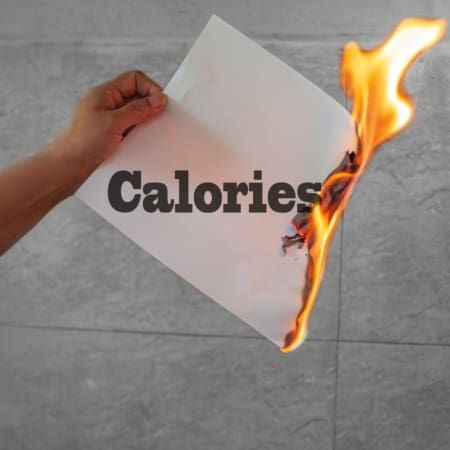

The **Calories Burnt Prediction** project aims to predict the number of calories burned during physical activity using machine learning. It leverages a dataset containing features like age, gender, height, heart rate, body temperature, and exercise duration. The project involves loading and merging datasets, performing exploratory data analysis (EDA), preprocessing, and training multiple regression models with hyperparameter tuning via GridSearchCV. The goal is to identify the best model for accurate calorie predictions, useful for fitness tracking or health applications.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae
import warnings
warnings.filterwarnings('ignore')

In [ ]:
exercise_url = 'https://raw.githubusercontent.com/VaibhavMishra1341/Calories-Burnt-Prediction/main/exercise.csv'
calories_url = 'https://raw.githubusercontent.com/VaibhavMishra1341/Calories-Burnt-Prediction/main/calories.csv'

df_exercise = pd.read_csv(exercise_url)
df_calories = pd.read_csv(calories_url)

data = pd.merge(df_exercise, df_calories, on='User_ID')
data.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


The dataset consists of two merged CSV files, exercise.csv and calories.csv, joined on User_ID. It contains 15,000 entries with features including:

Gender: Male/Female (categorical)
Age: Numeric (years)
Height: Numeric (cm)
Weight: Numeric (kg)
Duration: Exercise time (minutes)
Heart_Rate: Numeric (beats per minute)
Body_Temp: Numeric (°C)
Calories: Target variable (numeric, calories burnt)

In [ ]:
data.shape

(15000, 9)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Gender      15000 non-null  object 
 2   Age         15000 non-null  int64  
 3   Height      15000 non-null  float64
 4   Weight      15000 non-null  float64
 5   Duration    15000 non-null  float64
 6   Heart_Rate  15000 non-null  float64
 7   Body_Temp   15000 non-null  float64
 8   Calories    15000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.0+ MB


In [ ]:
data.describe()

,User_ID,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.497736e+07,42.789800,174.465133,74.966867,15.530600,95.518533,40.025453,89.539533
std,2.872851e+06,16.980264,14.258114,15.035657,8.319203,9.583328,0.779230,62.456978
min,1.000116e+07,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,1.247419e+07,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,35.000000
50%,1.499728e+07,39.000000,175.000000,74.000000,16.000000,96.000000,40.200000,79.000000
75%,1.744928e+07,56.000000,185.000000,87.000000,23.000000,103.000000,40.600000,138.000000
max,1.999965e+07,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


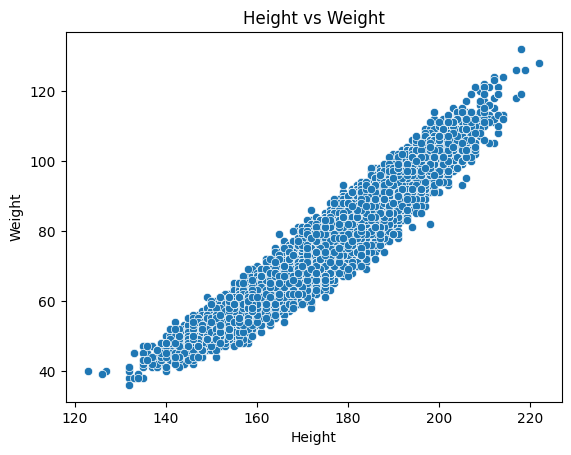

In [ ]:
sb.scatterplot(x = 'Height', y = 'Weight', data = data)
plt.title('Height vs Weight')
plt.show()

It creates a scatterplot using Seaborn to visualize the relationship between Height and Weight from the dataset, with a title "Height vs Weight" and displays the plot.

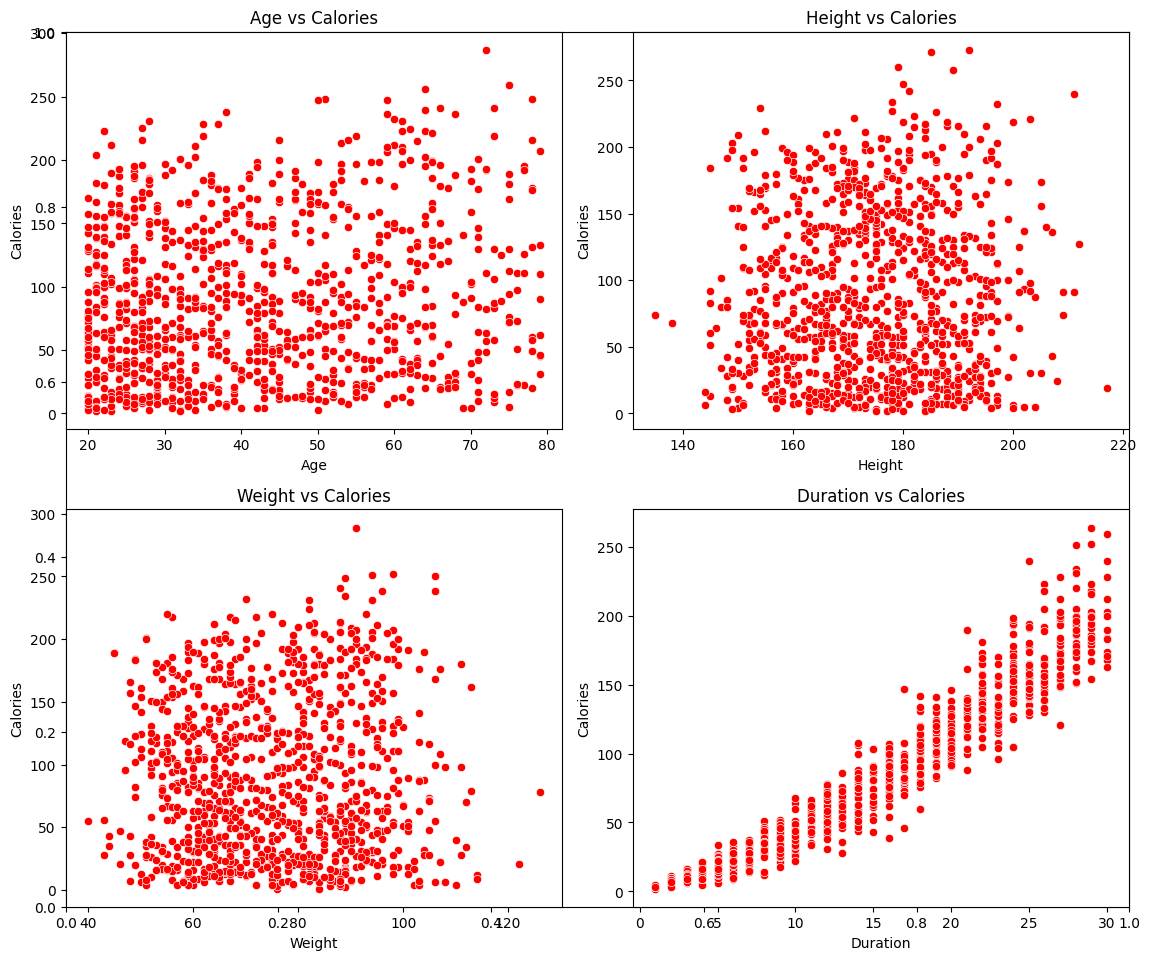

In [ ]:
features = ['Age', 'Height', 'Weight', 'Duration']
plt.subplots(figsize = (12, 10))
for i, col in enumerate(features):
    plt.subplot(2, 2, i + 1)
    x = data.sample(1000)
    sb.scatterplot(x = col, y = 'Calories', data = x, color = 'red')
    plt.title(f'{col} vs Calories')
plt.tight_layout()
plt.show()

It generates four scatterplots in a 2x2 grid, showing relationships between Age, Height, Weight, Duration and Calories using a random sample of 1,000 data points, with each plot titled "[Feature] vs Calories" and colored red.

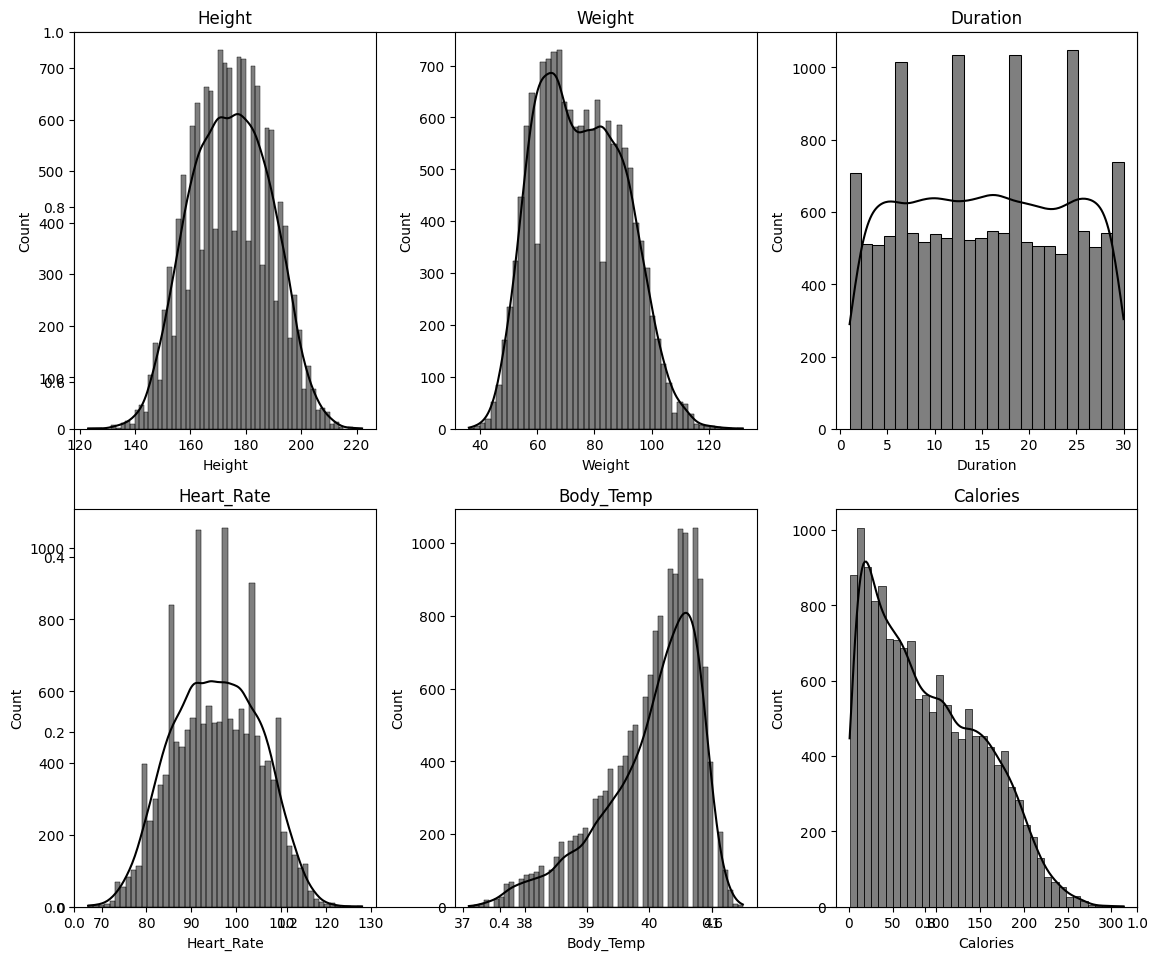

In [ ]:
features = data.select_dtypes(include = 'float').columns
plt.subplots(figsize = (12, 10))
for i, col in enumerate(features):
    plt.subplot(2, 3, i + 1)
    sb.histplot(data[col], kde = True, color = 'black')
    plt.title(col)
plt.tight_layout()
plt.show()

It creates histograms with kernel density estimation (KDE) for all float-type features in the dataset, arranged in a 2x3 grid, each titled with the feature name and colored black.

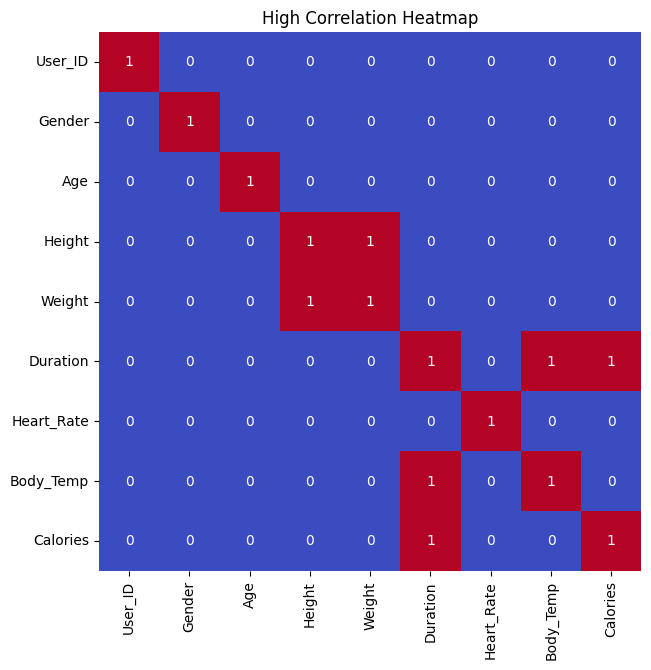

In [ ]:
data.replace({'male': 0, 'female': 1}, inplace = True)

plt.figure(figsize = (7, 7))
sb.heatmap(data.corr() > 0.9, annot = True, cbar = False, cmap = 'coolwarm')
plt.title('High Correlation Heatmap')
plt.show()

It replaces 'male' with 0 and 'female' with 1 in the dataset, then creates a 7x7 heatmap using Seaborn to show features with correlations above 0.9, annotated with values, using a 'coolwarm' colormap, titled "High Correlation Heatmap".

In [ ]:
remove = ['Weight', 'Duration']
data.drop(remove, axis = 1, inplace = True)

features = data.drop(['User_ID', 'Calories'], axis = 1)
target = data['Calories'].values

It drops 'Weight' and 'Duration' columns from the dataset to avoid multicollinearity, then separates features (excluding 'User_ID' and 'Calories') and the target variable ('Calories') for model training.

In [ ]:
# Splitting

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.1, random_state = 12)
print("Train shape:", x_train.shape, "Validation shape:", x_test.shape)

Train shape: (13500, 5) Validation shape: (1500, 5)


It splits the features and target into training and testing sets with a 90-10 ratio (test_size=0.1) using a random state of 12, and prints the shapes of the training and testing sets.

In [27]:
# Standardize

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

It applies StandardScaler to standardize the training features (fitting and transforming) and transforms the test features using the same scaler to ensure consistent scaling for model training.

In [23]:
models = [LinearRegression(), XGBRegressor(), Lasso(), RandomForestRegressor(), Ridge()]

model_names = ['Linear Regression', 'XGBoost Regressor', 'Lasso Regression', 'Random Forest Regressor', 'Ridge Regression']

for i, model in enumerate(models):
    model.fit(x_train, y_train)

    print(f'{model_names[i]}: ')

    train_pred = model.predict(x_train)
    print('Training MAE: ', mae(y_train, train_pred))

    test_pred = model.predict(x_test)
    print('Validation MAE: ', mae(y_test, test_pred))

    print('---')

Linear Regression: 
Training MAE:  17.967514151429132
Validation MAE:  17.48616996959723
---
XGBoost Regressor: 
Training MAE:  7.788597413498494
Validation MAE:  10.183086522658666
---
Lasso Regression: 
Training MAE:  17.983580769937888
Validation MAE:  17.5505421101431
---
Random Forest Regressor: 
Training MAE:  3.9679786402116406
Validation MAE:  10.526699222222224
---
Ridge Regression: 
Training MAE:  17.96758630612386
Validation MAE:  17.486313549685832
---


Initially, it defines a list of five regression models (LinearRegression, XGBRegressor, Lasso, RandomForestRegressor, Ridge) and their names. It trains each model on the training data, then prints the Training and Validation Mean Absolute Error (MAE) for each, looping through to evaluate performance on both sets.

The best model is XGBoost Regressor. Because it has the lowest validation MAE (10.18), indicating it generalizes best to unseen data. While Random Forest has a lower training MAE (3.98), its validation MAE (10.55) is slightly higher than XGBoost, suggesting XGBoost is less prone to overfitting.

In [24]:
# Tune XGBoost

params = {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 6]}

xgb_grid = GridSearchCV(XGBRegressor(random_state = 12), params, cv = 3, scoring = 'neg_mean_absolute_error')
xgb_grid.fit(x_train, y_train)

print("Best XGB params:", xgb_grid.best_params_)
print("Best XGB score (neg MAE):", xgb_grid.best_score_)

# Evaluate

xgb_tuned = xgb_grid.best_estimator_
xgb_train_preds = xgb_tuned.predict(x_train)
xgb_val_preds = xgb_tuned.predict(x_test)

print("Tuned XGB - Train MAE:", mae(y_train, xgb_train_preds))
print("Tuned XGB - Val MAE:", mae(y_test, xgb_val_preds))

Best XGB params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
Best XGB score (neg MAE): -10.186292057404984
Tuned XGB - Train MAE: 8.885819481774337
Tuned XGB - Val MAE: 9.92959839129448


It performs GridSearchCV on an XGBRegressor with parameters for n_estimators, learning_rate, and max_depth, using 3-fold cross-validation and negative MAE scoring. It prints the best parameters and score, then evaluates the tuned model by calculating and printing the Training and Validation MAE on the training and test sets.

Firstly, the tuned model has a lower validation MAE (9.93) compared to the untuned model (10.18). This indicates better generalization to unseen data, which is a clear improvement.

Secondly, the tuned model has a slightly higher training MAE, suggesting it may be less overfit to the training data. This is often a good sign when paired with a lower validation MAE, as it indicates better balance between fitting the training data and generalizing to new data.

In [ ]:
# Finally

***I WOULD LIKE TO EXPRESS MY SINCERE GRATITUDE FOR YOUR TIME AND CONSIDERATION***

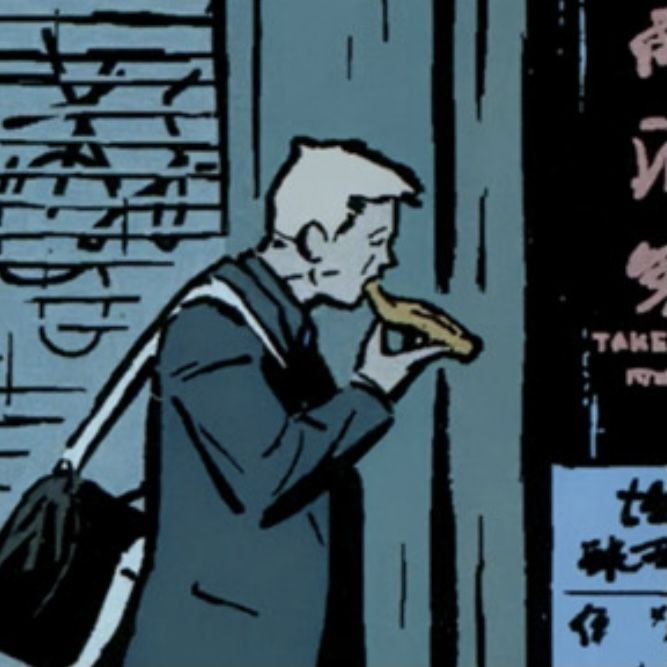